# Анализ ДТП в России на основе данных dtp-stat.ru
Это пример простого анализа статистики ДТП в России.
Посмотрим на следующие свойства данных:
- Структурированность данных
- Чистота данных
- Распределения наблюдаемых значений и признаков
- Корреляция по значений по признакам

## Шаг -1. Загрузка данных в локальные файлы
Этот шаг можно пропустить, если вы уже загружали файлы ранее.

In [ ]:
import requests as r
import os
import aiohttp
from bs4 import BeautifulSoup as bs

links = []
resp = r.get('https://dtp-stat.ru/opendata/')
if resp.ok:
    soup = bs(resp.text, "html.parser")
    for link in soup.findAll('a'):
        url = link.get('href')
        if '.geojson' in url: links.append('https://dtp-stat.ru' + url)
if len(links) == 85:
    print('Все регионы присутствуют на сайте. Загружаем')
else:
    print("Some regions are missed")
async with aiohttp.ClientSession() as session:
    for link in links:
        async with session.get(link) as resp:
            file_name = os.path.basename(link)
            with open('data/dtp-stat/' + file_name, 'w') as f:
                f.write(await resp.text())
                print('.', end='')
print(' готово.', end='')

## Шаг 0. Склейка файлов в один большой
Склеиваем все скачанные geojson файлы в один большой. Понадобится *много*(~15gb) памяти.

Этот шаг стоит выполнить если вы собираетесь анализировать весь массив данных сразу.

In [ ]:
import glob

files = glob.glob('data/dtp-stat/*')
import json

features = []
for file in files:
    with open(file) as f:
        d = json.load(f)
        features.extend(d['features'])
result = {
    "type": "FeatureCollection",
    "features": features
}
with open('data/dtp-stat/russia.geojson', 'w') as f:
    json.dump(result, f, ensure_ascii=False)
del result
del features

## Шаг 1.  Готовим pandas фрейм

Загружаем данные geojson файла в pandas фрейм. Посмотрим на структуру 


In [1]:
import pandas as pd
import json
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

sb.set_context("notebook", font_scale=1.5)

FILE_NAME = 'data/dtp-stat/altaiskii-krai.geojson'

with open(FILE_NAME) as f:
    d = map(lambda x: x['properties'], json.load(f)['features'])
df = pd.DataFrame.from_dict(d)
df.head(2)

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,[Сухое],2,[Все участники]
1,2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,"{'lat': 53.369248, 'long': 83.699802}","[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,[Мокрое],3,"[Дети, Все участники]"


Предущий шаг загрузил данные в датафрейм в памяти и вывел первые 2 строки фрейма.
## Приберемся в данных
- добавим индекс и метку времени
- списки преобразуем в строки
- строки сделаем категориями
- укоротим текст категорий для читаемости

In [2]:
#Индекс и метка времени
df.set_index('id', inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

# Разбиваем списочные признаки
def to_cats(series, prexix=''):
    flat_series = pd.Series([x for _list in series for x in _list])
    unique_items = flat_series.value_counts().index
    bool_dict = {}
    for item in unique_items:
        # Apply boolean mask
        bool_dict[prexix + item] = series.apply(lambda x: item in x)
        #bool_dict[prexix + item] = bool_dict[prexix + item].astype('category')
    return pd.DataFrame(bool_dict)

# Разбиваем освещенность на признаки
df['light'] = df['light'].apply(lambda s: map(str.strip, s.split(',')))

# Превращаем списки в бинарные категориальные признаки
for column in [ 'participant_categories','weather', 'road_conditions', 'light',  'nearby', ]:
    df = df.join(to_cats(df[column], column + '_'))
    df.drop(columns=[column], inplace=True)

# Размечаем категориальные признаки
for column in ['scheme', 'category', 'severity', 'region', 'parent_region']:
    df[column] = df[column].astype('category')
df['category'] = df['category'].cat.rename_categories(
    {
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ': 'Наезд на работника',
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы': 'Наезд на служащего',
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность': 'Наезд на другого',
        'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.': 'Возгорание на ходу'
    }
)

# Дропнем часть колонок которые пока не нужны
for column in ['point','address', 'tags']:
    df.drop(columns=[column], inplace=True)

В наборе данных у нас пока присуствуют три основных показателя
 - `participants_count`
 - `injured_count`
 - `dead_count`
Посмотрим на их распредение по некоторым категорийным данным

### Распределение количества участников, пострадавших и смертей по категории Тяжесть ДТП(severity)

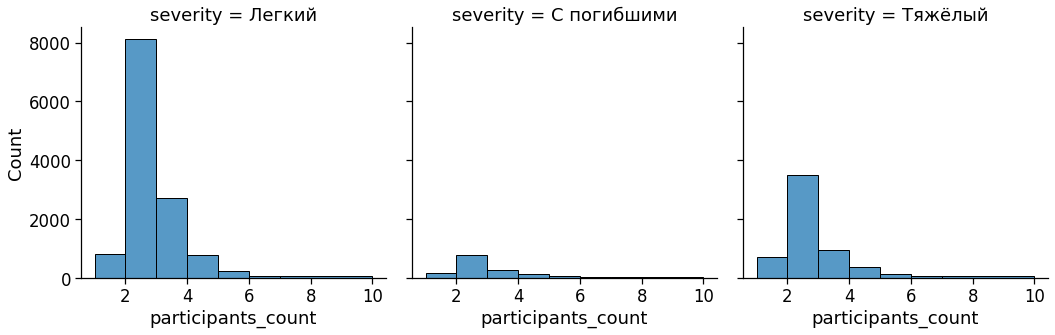

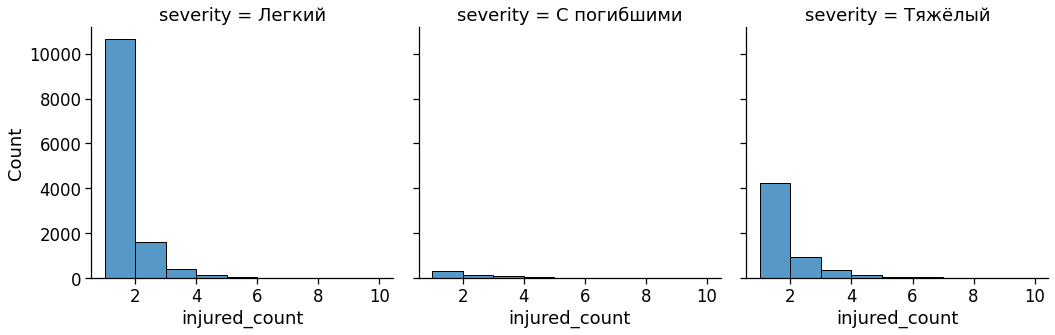

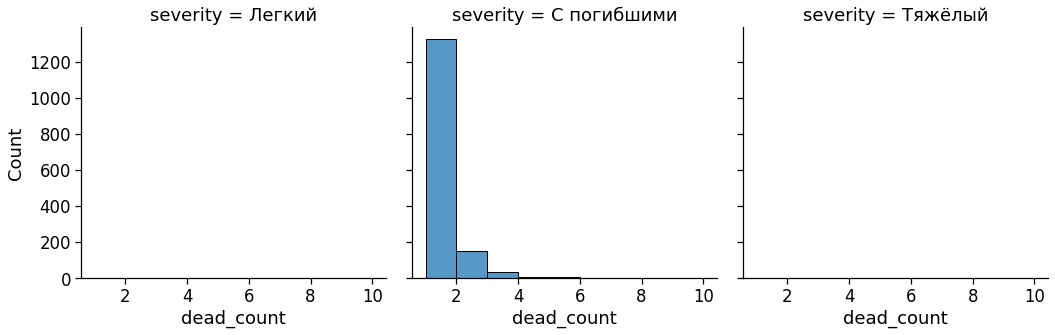

In [3]:
display(Markdown('### Распределение количества участников, пострадавших и смертей по категории Тяжесть ДТП(severity)'))
sb.displot(data=df, x='participants_count', col='severity', bins=[1, 2, 3, 4, 5, 6, 7, 10])
sb.displot(data=df, x='injured_count', col='severity', bins=[1, 2, 3, 4, 5, 6, 7, 10])
sb.displot(data=df, x='dead_count', col='severity', bins=[1, 2, 3, 4, 5, 6, 7, 10])
plt.show()

### Смертность по категориям

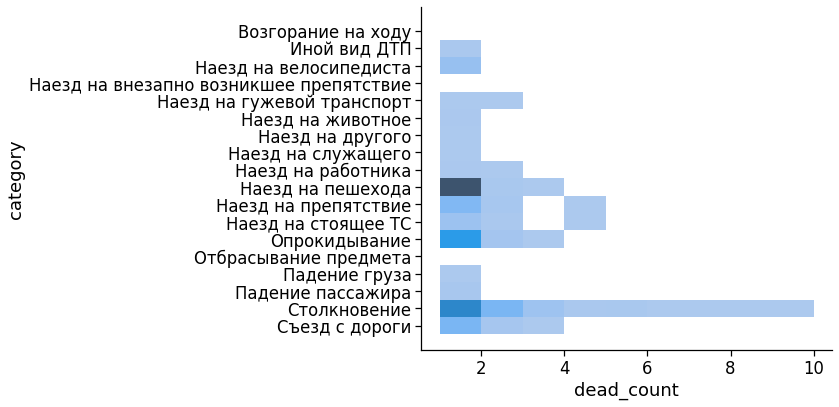

In [4]:
display(Markdown('### Смертность по категориям'))
sb.displot(df, x="dead_count", y='category', bins=[1, 2, 3, 4, 5, 6, 10, ], aspect=2, height=6)
plt.show()

### Онтошение смертности к пострадавшим

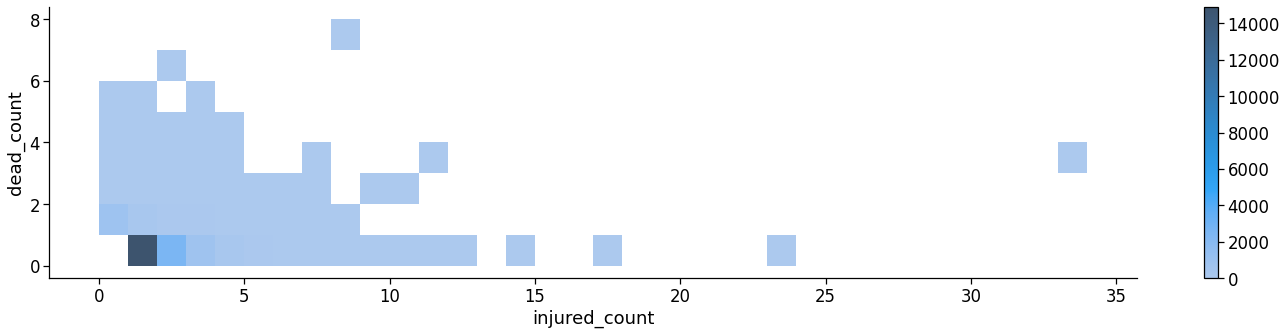

In [5]:
display(Markdown('### Онтошение смертности к пострадавшим'))
sb.displot(df, x="injured_count", y='dead_count', binwidth=(1, 1), cbar=True, aspect=4)
plt.show()

### Онтошение смертности к пострадавшим

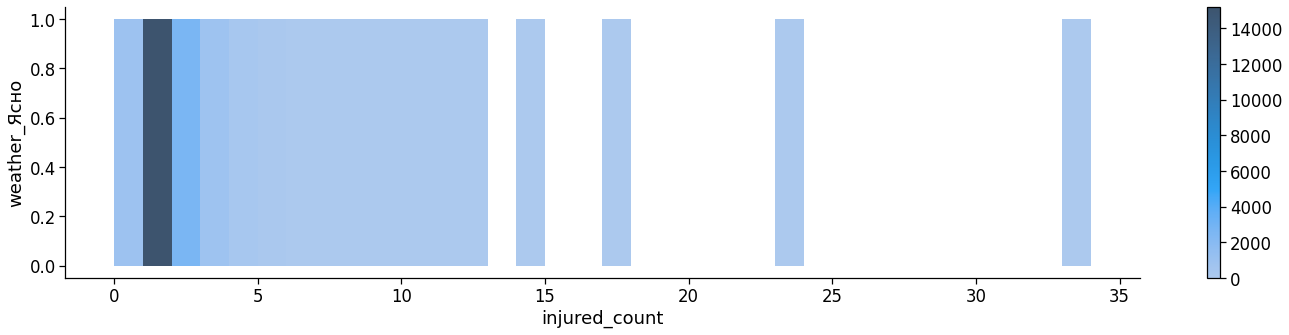

In [6]:
display(Markdown('### Онтошение смертности к пострадавшим'))
sb.displot(df, x="injured_count", y='weather_Ясно', binwidth=(1, 1), cbar=True, aspect=4)
plt.show()

### Корреляции признаков

,dead_count,injured_count,participants_count,participant_categories_Все участники,participant_categories_Пешеходы,participant_categories_Дети,participant_categories_Мотоциклисты,participant_categories_Велосипедисты,participant_categories_Общ. транспорт,weather_Ясно,...,nearby_СП ДПС (КПМ),nearby_Автовокзал (автостанция),nearby_Остановка маршрутного такси,nearby_Пункт весового контроля,nearby_Тоннель,nearby_Пешеходная зона,nearby_Нерегулируемое пересечение с круговым движением,"nearby_Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации","nearby_Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения",nearby_Место для перегона скота
dead_count,1.000000,-0.095011,0.155091,NaN,-0.023667,-0.015039,-0.002947,-0.014888,-0.028524,-0.003745,...,-0.003535,-0.002878,-0.001339,-0.005690,-0.004760,0.005002,-0.003116,-0.003116,-0.002544,-0.001799
injured_count,-0.095011,1.000000,0.753593,NaN,-0.242422,0.170464,-0.042959,-0.063302,-0.014018,-0.019407,...,0.023685,-0.011088,0.004469,-0.004395,0.000187,-0.008382,-0.003769,-0.003769,-0.003077,-0.002176
participants_count,0.155091,0.753593,1.000000,NaN,-0.207449,0.179060,-0.128426,-0.061835,0.006617,-0.044958,...,0.031238,-0.009469,-0.001150,-0.006160,0.002803,-0.008634,-0.008160,-0.004478,-0.003656,-0.002585
participant_categories_Все участники,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
participant_categories_Пешеходы,-0.023667,-0.242422,-0.207449,NaN,1.000000,0.071603,-0.132971,-0.140997,-0.054486,-0.077302,...,-0.010352,0.026157,0.015658,-0.002678,-0.008341,0.007949,-0.000619,0.016322,0.013326,-0.005248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nearby_Пешеходная зона,0.005002,-0.008382,-0.008634,NaN,0.007949,0.003130,0.022412,-0.002971,-0.002301,-0.012373,...,-0.000495,-0.000469,-0.000414,-0.000350,-0.000293,1.000000,-0.000192,-0.000192,-0.000156,-0.000111
nearby_Нерегулируемое пересечение с круговым движением,-0.003116,-0.003769,-0.008160,NaN,-0.000619,-0.004761,-0.003089,-0.002301,-0.001783,0.010210,...,-0.000383,-0.000364,-0.000321,-0.000271,-0.000227,-0.000192,1.000000,-0.000148,-0.000121,-0.000086
"nearby_Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иной детской организации",-0.003116,-0.003769,-0.004478,NaN,0.016322,-0.004761,-0.003089,-0.002301,-0.001783,-0.006285,...,-0.000383,-0.000364,-0.000321,-0.000271,-0.000227,-0.000192,-0.000148,1.000000,-0.000121,-0.000086
"nearby_Регулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения",-0.002544,-0.003077,-0.003656,NaN,0.013326,0.025445,-0.002522,-0.001879,-0.001455,-0.001765,...,-0.000313,-0.000297,-0.000262,-0.000221,-0.000185,-0.000156,-0.000121,-0.000121,1.000000,-0.000070


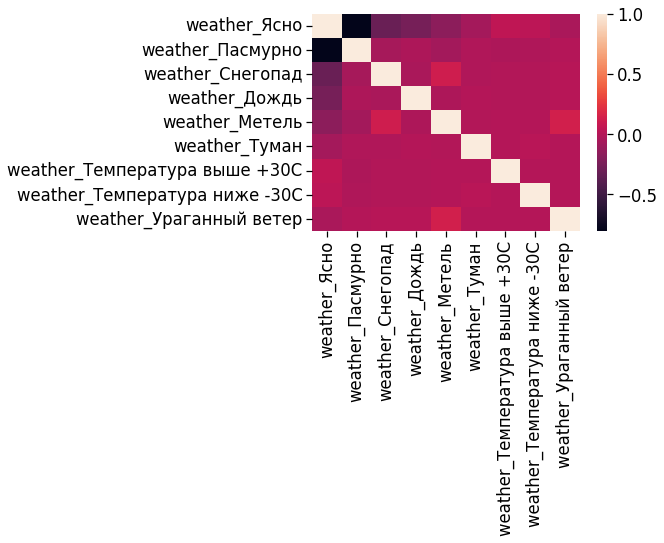

In [13]:
display(Markdown('### Корреляции признаков'))

display(df.corr(method = "pearson"))

sb.heatmap(df.filter(regex='^weather',axis=1).corr(method = "pearson"))
plt.show()

## Примеры похожих исследований на Kaggle
- [https://www.kaggle.com/sobhanmoosavi/us-accidents/tasks](us-accidents)
- [https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales](1.6 million UK traffic accidents)
- [https://www.kaggle.com/amadeus1996/eda-visualizations-for-accidents-in-france](Visualizations for Accidents in France)